<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_10_2D_Linear_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Linear Estimation of Transformations

# Some Conventions

We will use the following notation to represent these transformations generically.

\begin{equation}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p})
\end{equation}

where $\mathbf{p}$ is the set of parameters to be estimated.
    
For numerical convenience of choosing initialization, we usually reparameterize the transformations so that **when the parameters, $\mathbf{p}$, are all zero, the point does not move**. To achieve this, we add a 1 to the first two diagonal values of the transformation matrix. See Table 6.1

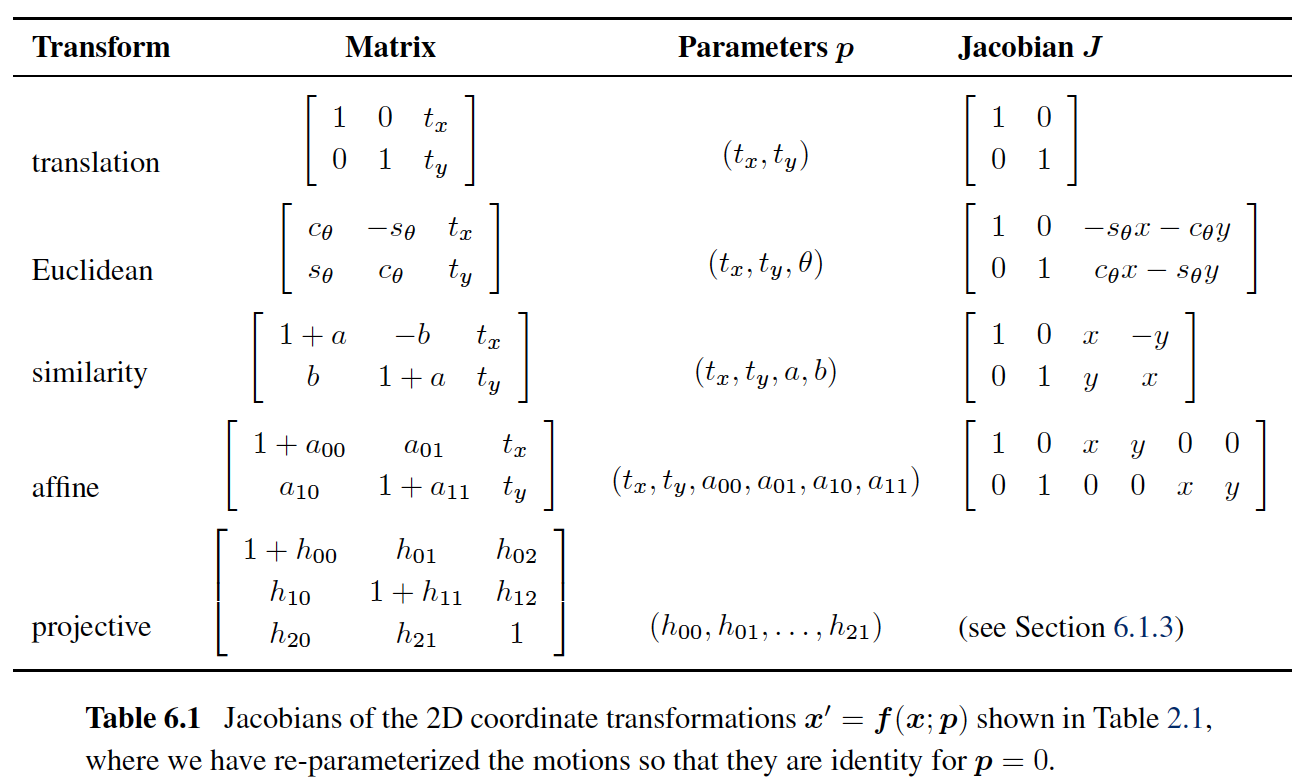

# Starting point - corresponding points

The starting point of the estimation is the corresponding pairs of points between two images. There are many ways to computing these correspondences. Here we use the OpenCV solution using SIFT features and descriptors, which works well in many circumstances.

In [12]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Armes 1.png'				    lizard.jpg
'Armes 2.png'				    MOT16-08-raw.webm
 blog_danforth_monica_mural_panorama.jpg    mountain_peak_1.png
 blog_monica_mural_brown_white.jpg	    mountain_peak_2.png
 blog_monica_mural_fish_tree_windows1.jpg   parking_lot_meva_1.png
 hawaii.png				    parking_lot_meva_2.png
 house_1.png				    parking_lot_meva_3.png
 house_2.png				    window_1.png
 house_facade.png			    window_2.png


In [13]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn

!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)


np.set_printoptions(precision=2, suppress=True)

4.4.0


Input image size: (223, 324)


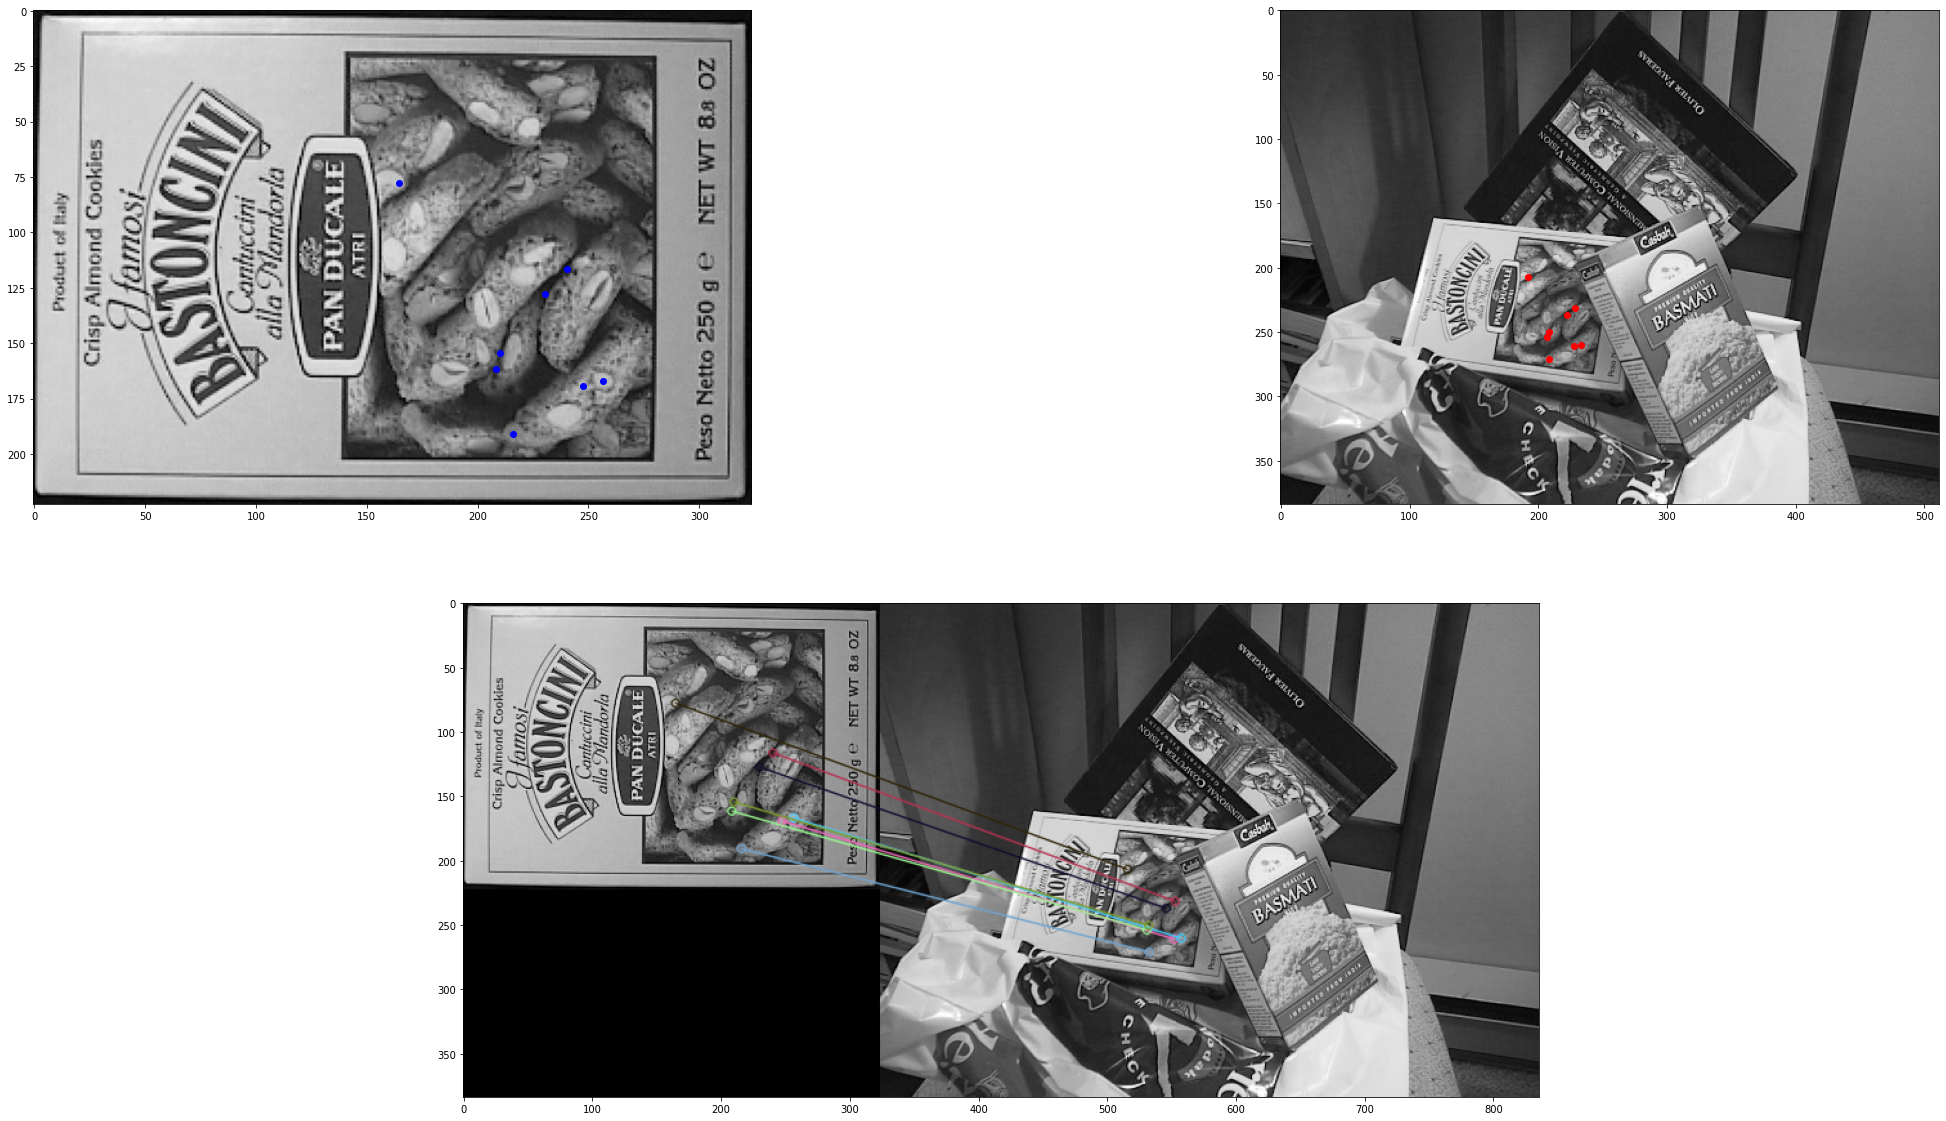

In [108]:
from skimage import io

#image_1 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_danforth_monica_mural_panorama.jpg')
#image_2 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_monica_mural_fish_tree_windows1.jpg')
#num_matches = 10

image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
image_2 = io.imread('https://i.stack.imgur.com/gAz96.png')
num_matches = 8

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
print("Input image size:", image_1.shape)

sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)

keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

# FEATURE MATCHING
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
X_1 = []
X_2 = []
for i in range(num_matches) :
    X_1.append([keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1]])
    X_2.append([keypoints_2[matches[i].trainIdx].pt[0], keypoints_2[matches[i].trainIdx].pt[1]])
X_1 = np.array(X_1)
X_2 = np.array(X_2)
#----------------------------------Display-------------------------------------------------------
# draw matches
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[0:num_matches], image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image)

# save the image
# cv2.imwrite("table-sift.jpg", sift_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# 2D affine alignment

Given a set of corresponding points between two 2D patches, $\{(\widetilde{\mathbf{x_i}}', \widetilde{\mathbf{x_i}})|i=1, \cdots n\}$ find the transformation between them. We will first consider the affine transformation, which is **linear with respect to the parameters**. Note this concept of linearity is different from the transformation being linear. All the geometric transformations we have studied are linear.
    
We have three points to consider: the initial point $\widetilde{\mathbf{x_i}}$, the transformed point using the transformation, $\mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p})$, and the final point, $\widetilde{\mathbf{x_i}}'$. 

We have two differences, as depicted below, $(\widetilde{\mathbf{x_i}}' -\widetilde{\mathbf{x_i}})$, the **disparity** between the points being matched, and the **residual error **of the transformation, $(\mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) - \mathbf{x_i'}) $. We want to find a transformation $f$ such as the residual error is minimized. 

We next derive an expression that related the residual error with the disparity *for one point*. We will then sum this quantity over all the points to arrive at the total residual.
    

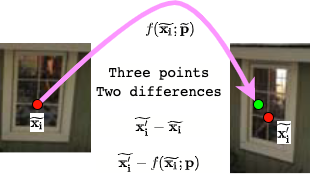

The residual (the error) of the $i$-th points is given by 

\begin{eqnarray}
    \mathbf{r}_i & = & f (\widetilde{\mathbf{x_i}}; \mathbf{p}) - \widetilde {\mathbf{x_i}}^{'}\\
    & = & \begin{bmatrix}
        a_{00}+1 & a_{01} & t_x \\
        a_{10} & a_{11} + 1 & t_y \\
        0  & 0 & 1
    \end{bmatrix} \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix}\\
    & = & \left ( \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0  & 0 & 0
    \end{bmatrix} + \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0  & 0 & 1
    \end{bmatrix} \right ) \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - \begin{bmatrix}
        \hat{x}_i' \\ y_i' \\ 1
    \end{bmatrix}\\
    & = & 
    \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0  & 0 & 0
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i \\ 0
    \end{bmatrix} \\
        & = & 
    \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y 
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i 
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i 
    \end{bmatrix} \\
\end{eqnarray}
\begin{eqnarray}
    \mathbf{r}_i^{2 \times 1}  & = & 
    \begin{bmatrix}
        x_i & y_i & 1 & 0 & 0 & 0\\
        0   & 0 & 0  & x_i & y_i & 1
    \end{bmatrix}
    \begin{bmatrix}
        a_{00} \\ a_{01} \\ t_x \\ a_{10} \\ a_{11} \\ t_y 
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i 
    \end{bmatrix} \\
        & = & J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i}
\end{eqnarray}

Note that $\Delta \mathbf{x_i} = (\mathbf{x_i}' - \mathbf{x_i})$ is the difference between initial and new point. 

# Jacobian for Affine Transformation

The affine transformation is further generalized version of the similarity transform.

\begin{eqnarray}
    \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) = 
\begin{bmatrix}
    f_x \\ f_y \\ 1
\end{bmatrix} 
    & = & 
    \begin{bmatrix}
        1+a_{00} & a_{01} & t_x \\
        a_{10} & 1+a_{11} & t_y \\
        0  & 0 & 1
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}
\end{eqnarray}

The parameter vector is four dimensional 
$\mathbf{p} = 
\begin{bmatrix}
    a_{00} \\ a_{01} \\ t_x \\ a_{10} \\ a_{11} \\ t_y
\end{bmatrix}$. 

Like earlier, we have parameterized the transformation in such a way that $\mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}=0) = \widetilde{\mathbf{x_i}}$ or $\mathbf{p}=0$ results in an identity transformation.



The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i)}$ is given by


\begin{eqnarray}
    \frac{\partial}{\partial \mathbf{p}} \mathbf{f} (\widetilde{\mathbf{x_i}}; \mathbf{p}) & = & 
\begin{bmatrix}
        \frac{\partial}{\partial a_{00}} f_x & 
        \frac{\partial}{\partial a_{01}} f_x & 
        \frac{\partial}{\partial t_x} f_x & 
        \frac{\partial}{\partial a_{10}} f_x &
        \frac{\partial}{\partial a_{11}} f_x &
        \frac{\partial}{\partial t_y} f_x \\
        \frac{\partial}{\partial a_{00}} f_y & 
        \frac{\partial}{\partial a_{01}} f_y & 
        \frac{\partial}{\partial t_x} f_y & 
        \frac{\partial}{\partial a_{10}} f_y &
        \frac{\partial}{\partial a_{11}} f_y &
        \frac{\partial}{\partial t_y} f_y
        \end{bmatrix}  \\
    & = & 
\begin{bmatrix}
    x_i & y_i & 1 & 0     & 0 & 0\\
    0   & 0   & 0 & x_i & y_i & 1
\end{bmatrix}
\end{eqnarray}

Note that like the similarity transform the components of the Jacobian do not involve the parameters being estimated. Because of this property, we would be able to solve this particular problem in a non-iterative fashion, i.e. there is a closed form expression of the solution.

# Total residual

The total error is given by sum of the squared resiudals, which is the L2 norm.  Note that are other possible forms for the total error, such as sum of absolute values of the residual (L1 norm), or weighted L2 norms (robust estimators). 

\begin{eqnarray}
    r & = & \sum_i || \mathbf{r}_i||^2 \\
    & = & \sum_i \mathbf{r}_i^T \mathbf{r}_i = \sum_i \begin{bmatrix}
        - & -
    \end{bmatrix}\begin{bmatrix}
        - \\ -
    \end{bmatrix} \\
    & = & \sum_i \left ( J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i} \right )^T \left ( J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i} \right ) \\
    & = & \sum_i \left ( \mathbf{p}^T J(\mathbf{x_i})^T - \Delta \mathbf{x_i}^T \right ) \left ( J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i} \right ) \\
    & = & \sum_i \mathbf{p}^T J(\mathbf{x_i})^T J(\mathbf{x_i}) \mathbf{p} - 2 \mathbf{p}^T J(\mathbf{x_i})^T \Delta \mathbf{x_i} + \Delta \mathbf{x_i}^T \Delta \mathbf{x_i} \\
    & = & \mathbf{p}^T \left ( \sum_i  J(\mathbf{x_i})^T J(\mathbf{x_i}) \right) \mathbf{p} - 2 \mathbf{p}^T \left ( \sum_i J(\mathbf{x_i})^T \Delta \mathbf{x_i}\right )  + \sum_i \Delta \mathbf{x_i}^T \Delta \mathbf{x_i} \\
     & & \\
    & = & \color{red}{\mathbf{p}^T \mathbf{A}^{6 \times 6} \mathbf{p} - 2 \mathbf{p}^T \mathbf{b}^{6 \times 1}  + c} \\
    & = & \begin{bmatrix}
        ? & ? & ? & ? & ? & ? \\
    \end{bmatrix}
    \begin{bmatrix}
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - 
    \end{bmatrix}
    \begin{bmatrix}
        ? \\ ? \\ ? \\ ? \\ ? \\ ? 
    \end{bmatrix}  \\
    &  & - 2 \begin{bmatrix}
        - & - & - & - & - & - \\
    \end{bmatrix}
    \begin{bmatrix}
            ? \\ ? \\ ? \\ ? \\ ? \\ ? 
    \end{bmatrix} + \begin{bmatrix}
        -
    \end{bmatrix}
\end{eqnarray}

# Hessian

The quantity Hessian is named after [Otto Hesse](https://en.wikipedia.org/wiki/Otto_Hesse).

"In mathematics, the Hessian matrix or Hessian is a square matrix of **second-order partial derivatives** of a scalar-valued function, or scalar field. It describes the **local curvature of a function **of many variables." For more see the [Wikipedia](https://en.wikipedia.org/wiki/Hessian_matrix) page.

The second-order partial derivatives of our optimized quantity is the matrix $\mathbf{A}$, which is the Hessian for this problem:

\begin{eqnarray}
    \mathbf{A} & = & \sum_i  J(\mathbf{x_i})^T J(\mathbf{x_i}) \\
    & = & \sum_i \begin{bmatrix}
        x_i & 0 \\
        y_i & 0 \\
        1 & 0 \\
        0 & x_i \\
        0 & y_i \\
        0 & 1 \\
        \end{bmatrix} \begin{bmatrix}
         x_i & y_i & 1 &  0 & 0 & 0 \\
         0   & 0   &0 &  x_i & y_i & 1
        \end{bmatrix} \\
    & = & \sum_i 
    \begin{bmatrix}
    x_i^2 & x_i y_i & x_i & 0 & 0 & 0 \\
    x_i y_i & y_i^2 & y_i & 0 & 0 & 0 \\
    x_i & y_i & 1 & 0 &  0 & 0 \\
    0 & 0 & 0 & x_i^2 & x_i y_i & x_i \\
    0 & 0 & 0 & x_i y_i & y_i^2 & y_i \\
    0 & 0 & 0 & x_i & y_i & 1
    \end{bmatrix} \\
    & = &
    \begin{bmatrix}
    \sum_i x_i^2 & \sum_i x_i y_i & \sum_i x_i & 0 & 0 & 0 \\
    \sum_i x_i y_i & \sum_i y_i^2 & \sum_i y_i & 0 & 0 & 0 \\
    \sum_i x_i & \sum_i y_i & N & 0 &  0 & 0 \\
    0 & 0 & 0 & \sum_i x_i^2 & \sum_i x_i y_i & \sum_i x_i \\
    0 & 0 & 0 & \sum_i x_i y_i & \sum_i y_i^2 & \sum_i y_i \\
    0 & 0 & 0 & \sum_i x_i & \sum_i y_i & N
    \end{bmatrix}
\end{eqnarray}
    

\begin{eqnarray}
    \mathbf{b} & = &  \sum_i J(\mathbf{x_i})^T \Delta \mathbf{x_i} \\
    & = & \sum_i 
    \begin{bmatrix}
        x_i & 0 \\
        y_i & 0 \\
        1 & 0 \\
        0 & x_i \\
        0 & y_i \\
        0 & 1 
    \end{bmatrix} 
    \begin{bmatrix}
        \Delta x_i \\ \Delta y_i
    \end{bmatrix} \\
    & = & 
    \begin{bmatrix}
        \sum_i x_i \Delta x_i \\
        \sum_i y_i \Delta x_i \\
        \sum_i \Delta x_i \\
        \sum_i x_i \Delta y_i \\
        \sum_i y_i \Delta y_i \\
        \sum_i \Delta y_i 
    \end{bmatrix}
\end{eqnarray}

# Computing the Hessian ($\mathbf{A}$) and $\mathbf{b}$ using matrix operations

The above Hessian, $\mathbf{A}$, and the vector $\mathbf{b}$  can be computed entirely using matrix operations as follows:

Let the corresponding pairs of points be stored the two matrices as shown below. The corresponding columns in the two matrices store the corresponding pairs of points.

\begin{equation}
\mathbf{X} = \begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix},  \mathbf{X'} = \begin{bmatrix}
    x_1' & x_2' & \cdots & x_N' \\
    y_1' & y_2' & \cdots & y_N' \\
    1   &  1  & \cdots & 1 
\end{bmatrix}
\end{equation}

If we multiply the coordinates of one set as, $\mathbf{X} \mathbf{X}^T$, we end up with a 3 by 3 matrix as shown below. This matrix is the moment matrix.

\begin{eqnarray}
\mathbf{X}  \mathbf{X}^T & = & 
\begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix} 
\begin{bmatrix}
    x_1 & y_1 & 1 \\
    x_2 & y_2 & 1 \\
    \vdots \\
    x_N & y_N& 1
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\sum_i x_i^{2} & \sum_i x_i y_i & \sum_i x_i  \\
    \sum_i x_i y_i & \sum_i y_i^2 & \sum_i y_i  \\
    \sum_i x_i & \sum_i y_i & N & \\
\end{bmatrix}
\end{eqnarray}

If you compare this 3 by 3 matrix with the expression for the Hessian matrix $\mathbf{A}$ for this problem, we see that the Hessian matrix can be constructed as follows.

\begin{equation}
\mathbf{A} = 
\begin{bmatrix}
\mathbf{X}  \mathbf{X}^T & \mathbf{0}^{3 x 3} \\
\mathbf{0}^{3 x 3} & \mathbf{X}  \mathbf{X}^T 
\end{bmatrix}
\end{equation}

The vector $\mathbf{b}$ can also be computed in as similar manner. Consider the
displacement between the corresponding points are stored in the following matrix. 

\begin{eqnarray}
    \Delta \mathbf{X}^{2 \times N} & = & 
    \left (\mathbf{X'} - \mathbf{X} \right) 
\end{eqnarray}

Now consider the product $ \mathbf{X} (\Delta \mathbf{X})^T$.
\begin{eqnarray}
\mathbf{X} (\Delta \mathbf{X})^T & = & 
\begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix} 
\begin{bmatrix}
    x_1^{'} - x_1 &  y_1^{'} - y_1 & 0 \\
    x_2^{'} - x_2 &  y_2^{'} - y_2 & 0\\
    \vdots & \vdots & \vdots\\
    x_N^{'} - x_N &  y_N^{'} - y_N & 0
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\sum_i x_i (x_i^{'} - x_i) & \sum_i x_i (y_i^{'} - y_i) & 0 \\
\sum_i y_i (x_i^{'} - x_i) & \sum_i y_i (y_i^{'} - y_i) & 0 \\
\sum_i (x_i^{'} - x_i) & \sum_i (y_i^{'} - y_i) & 0 \\
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\sum_i x_i \Delta x_i & \sum_i x_i \Delta y_i  & 0 \\
\sum_i y_i \Delta x_i  & \sum_i y_i \Delta y_i  & 0 \\
\sum_i \Delta x_i & \sum_i \Delta y_i  & 0 \\
\end{bmatrix} \\
\end{eqnarray}

If we compare the form of the vector $\mathbf{b}$ we had derived earlier, you will see that it can contructed from the above 3 by 3 matrix by stacking the first two columns. 

    

# An example

In [51]:
X = np.row_stack((X_1.transpose(1,0), np.ones((1, X_1.shape[0]))))
print('X=\n', X)

X_dash = np.row_stack((X_2.transpose(1,0), np.ones((1, X_2.shape[0]))))
print('X_dash=\n', X_dash)

M = X @ X.transpose(1,0)
A1 = np.column_stack((M, np.zeros((3,3))))
A2 = np.column_stack((np.zeros((3,3)), M))
A = np.row_stack((A1, A2))
print('A =\n', A)

b_dash = X @ (X_dash - X).transpose(1,0)
b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))
print('b =\n', b)

X=
 [[240.45 164.62 247.45 230.19 215.96 208.33 256.41 210.07 204.06 196.03]
 [116.58  77.97 169.25 127.66 190.95 161.66 166.98 154.61 219.34 122.22]
 [  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.  ]]
X_dash=
 [[228.84 191.95 228.05 221.87 208.55 206.88 233.5  208.34 352.89 203.98]
 [231.64 206.92 260.93 237.15 271.02 253.94 260.31 250.4   21.71 231.64]
 [  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.  ]]
A =
 [[479121.67 331061.99   2173.58      0.        0.        0.  ]
 [331061.99 242041.4    1507.21      0.        0.        0.  ]
 [  2173.58   1507.21     10.        0.        0.        0.  ]
 [     0.        0.        0.   479121.67 331061.99   2173.58]
 [     0.        0.        0.   331061.99 242041.4    1507.21]
 [     0.        0.        0.     2173.58   1507.21     10.  ]]
b =
 [[ 18779.51]
 [ 24304.55]
 [   111.28]
 [158476.95]
 [ 83590.46]
 [   718.45]]


# Linear Solution

Going back to our optimization function, our residual, $r$, is given by:

\begin{equation}
r  =  \mathbf{p}^T \mathbf{A}^{6 \times 6} \mathbf{p} - 2 \mathbf{p}^T \mathbf{b}^{6 \times 1}  + c
\end{equation}

To find the minimum of the total residual, we take a derivative with respect to the parameters and set it to zero.
    
\begin{eqnarray}
    \frac{\partial r}{\partial \mathbf{p}} & = & 0 \\
    \mathbf{A} \mathbf{p}  & = &\mathbf{b} \\
    \mathbf{p}  & = \mathbf{A}^{-1} &\mathbf{b}
\end{eqnarray}
    
When does the inverse exist? What is the minimum number of point correspondences do we need?
    
Instead of the inverse (or pseudo-inverse), solving this via [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) is more stable. The pseudo-inverse is numerically unstable if the lowest eigenvalue is close to zero. In other words, the minimization problem has multiple solutions, and it is ill-conditioned.  This condition could be the case if points are clustered together, i.e., not spread out across the region of interest. Sich clustering is less likely to happen in the current computing affine transformations between point sets. Still, it can occur in other settings where we need to compute the linear least-squares estimate. **Hence, the solving via QR decomposition is something that you need to know and keep in mind as an option.** 

\begin{eqnarray}
    \mathbf{A} \mathbf{p}  & = &\mathbf{b} \\
    \mathbf{Q} \mathbf{R}\mathbf{p}  & = &\mathbf{b} \\
    \mathbf{R}\mathbf{p}  & = & \mathbf{Q}^T \mathbf{b}
\end{eqnarray}
    
where $\mathbf{Q}$ is an orthonormal matrix, $\mathbf{Q}\mathbf{Q}^T = \mathbf{I}$ and $\mathbf{R}$ is an upper triangular matrix. The solution for $\mathbf{p}$ is constructed by working the upper triangular matrix from the last row upwards towards the first row.
    
QR decomposition is the basis of more complex algorithms, such as computing the inverse, SVD, and eigenvalue decompositions. **Unlike the SVD and eigenvalue decompositions, QR factorization does not require iteration and can be computed precisely in $\mathcal{O}(MN^2 + N^3)$ operations, for a $M \times N$ matrix.** 

# Solution of linear optimization using QR decomposition




In [37]:
def qr_solve (A, b) :
    # A is n by n matrix, b is a n by 1 vector
    # returns a n by 1 vector as a solution
    
    Q, R = np.linalg.qr(A, 'reduced')
    b_dash = Q.transpose(1,0) @ b
    Np = b_dash.shape[0]
    del_p = np.zeros((Np, 1))
    for i in range(Np-1, -1, -1): # work from the last row of R
        sum_r_p = [0]
        for j in range(i+1, Np, 1) :
            sum_r_p += R[i, j]*del_p[j]
        del_p[i] = (b_dash[i]- sum_r_p)/R[i,i]

    return(del_p)

# Affine Transformation Estimation Code

In [60]:
def fit_affine (Points_1, Points_2) :
    # input: two 2D points sets, each of size N by 2
    # output: residual of fit and the best fitting affine transformation

    # Rearrange the points in 3 by N arrays of homogeneous representation of the points
    X = np.row_stack((Points_1.transpose(1,0), np.ones((1, Points_1.shape[0]))))
    X_dash = np.row_stack((Points_2.transpose(1,0), np.ones((1, Points_2.shape[0]))))

    # Compute the Hessian from the point coordinate moments
    M = X @ X.transpose(1,0)
    A1 = np.column_stack((M, np.zeros((3,3))))
    A2 = np.column_stack((np.zeros((3,3)), M))
    A = np.row_stack((A1, A2))
    print('A =\n', A)

    # vector b
    b_dash = X @ (X_dash - X).transpose(1,0)
    b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))
    print('b =\n', b)

    p = qr_solve (A, b) 

    p = p.squeeze()
    # the parameter vector is [a_00, a_01, t_x, a_10, a_11, t_y]
    # rearrange it back into homogeneous matrix representation
    T_affine = np.row_stack((p.reshape(2, 3), [0, 0, 0])) + np.eye(3)
    T_affine_inv = np.linalg.inv(T_affine)

    X_t = T_affine @ X
    residual_error = np.sum(np.power((X_dash - X_t), 2))
    return(residual_error, T_affine)


# Affine transform the image

A =
 [[399051.26 262344.89   1773.48      0.        0.        0.  ]
 [262344.89 178995.15   1165.66      0.        0.        0.  ]
 [  1773.48   1165.66      8.        0.        0.        0.  ]
 [     0.        0.        0.   399051.26 262344.89   1773.48]
 [     0.        0.        0.   262344.89 178995.15   1165.66]
 [     0.        0.        0.     1773.48   1165.66      8.  ]]
b =
 [[-13149.95]
 [ -9311.85]
 [   -45.51]
 [177353.82]
 [113563.89]
 [   806.65]]
Residual error=2.0016130388443543
 T =
[[  0.55  -0.1  109.2 ]
 [  0.06   0.54 155.02]
 [  0.     0.     1.  ]]
 T_inv =
[[   1.8     0.32 -246.63]
 [  -0.19    1.81 -260.36]
 [   0.      0.      1.  ]]


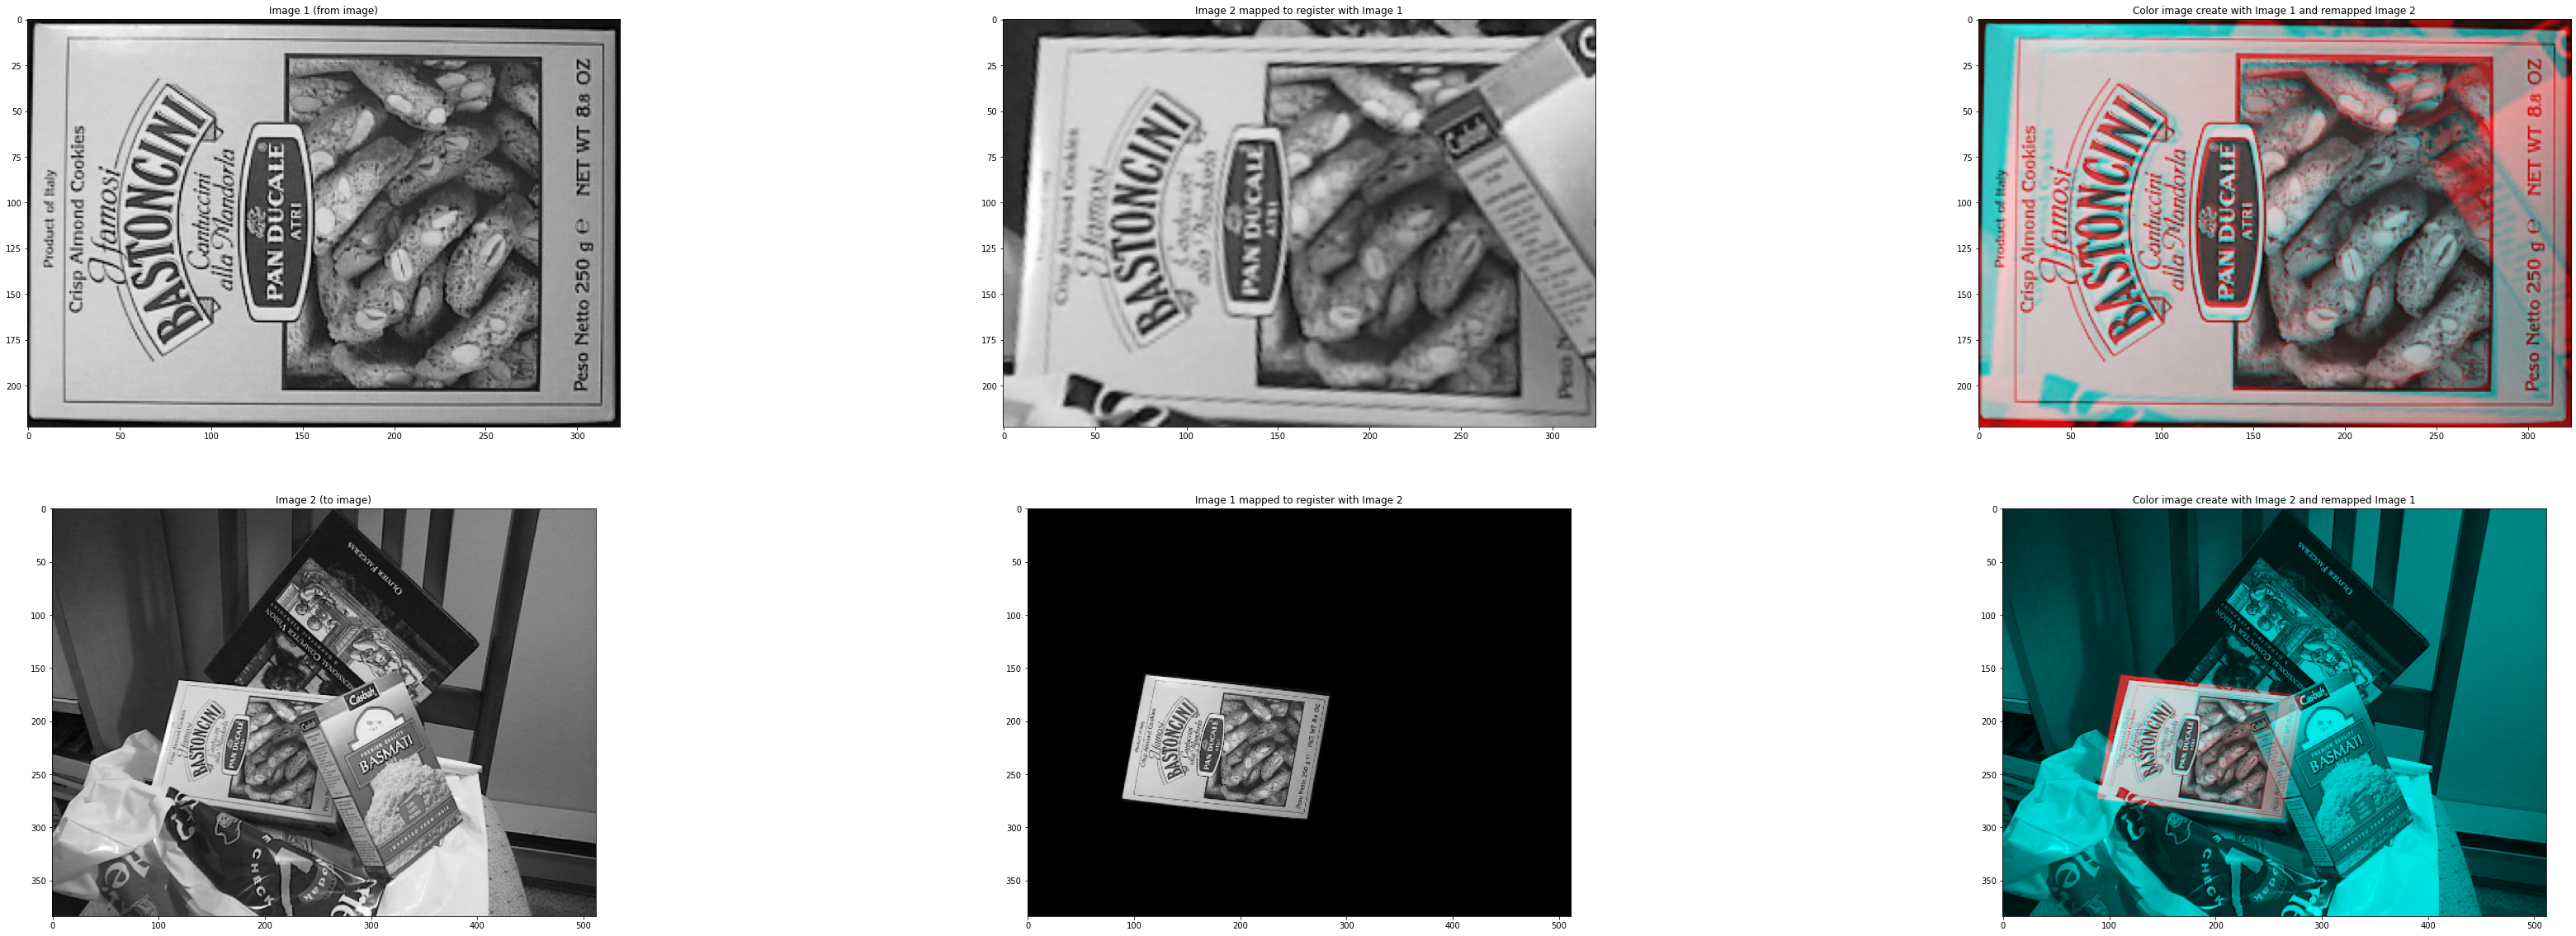

In [109]:
from skimage.transform import warp

residual_error, T_affine = fit_affine(X_1, X_2)

T_affine_inv = np.linalg.inv(T_affine)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual_error, T_affine, T_affine_inv))


warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (60, 20))
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1');


# Inclass work -- Sensitivity to outlier matches

Change the number of matches selected from 8 to 10 to 20 and document the effect observed. Do you have any suggestions about to handle outlier (wrong) matches)?

# Robust estimation

For more broad introduction to this topic see https://en.wikipedia.org/wiki/Robust_regression

residual error = 64.35041192661613, remove match # 8
residual error = 48.5398298447201, remove match # 20
residual error = 32.47347077688201, remove match # 28
residual error = 13.591865045939903, remove match # 38
residual error = 1.0655396871421734, remove match # 34
residual error = 0.9967405530043729, remove match # 40
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Residual error=0.9967405530043729
 T =
[[  0.53  -0.1  111.64]
 [  0.07   0.53 154.55]
 [  0.     0.     1.  ]]
 T_inv =
[[   1.83    0.33 -255.72]
 [  -0.23    1.85 -259.39]
 [   0.      0.      1.  ]]


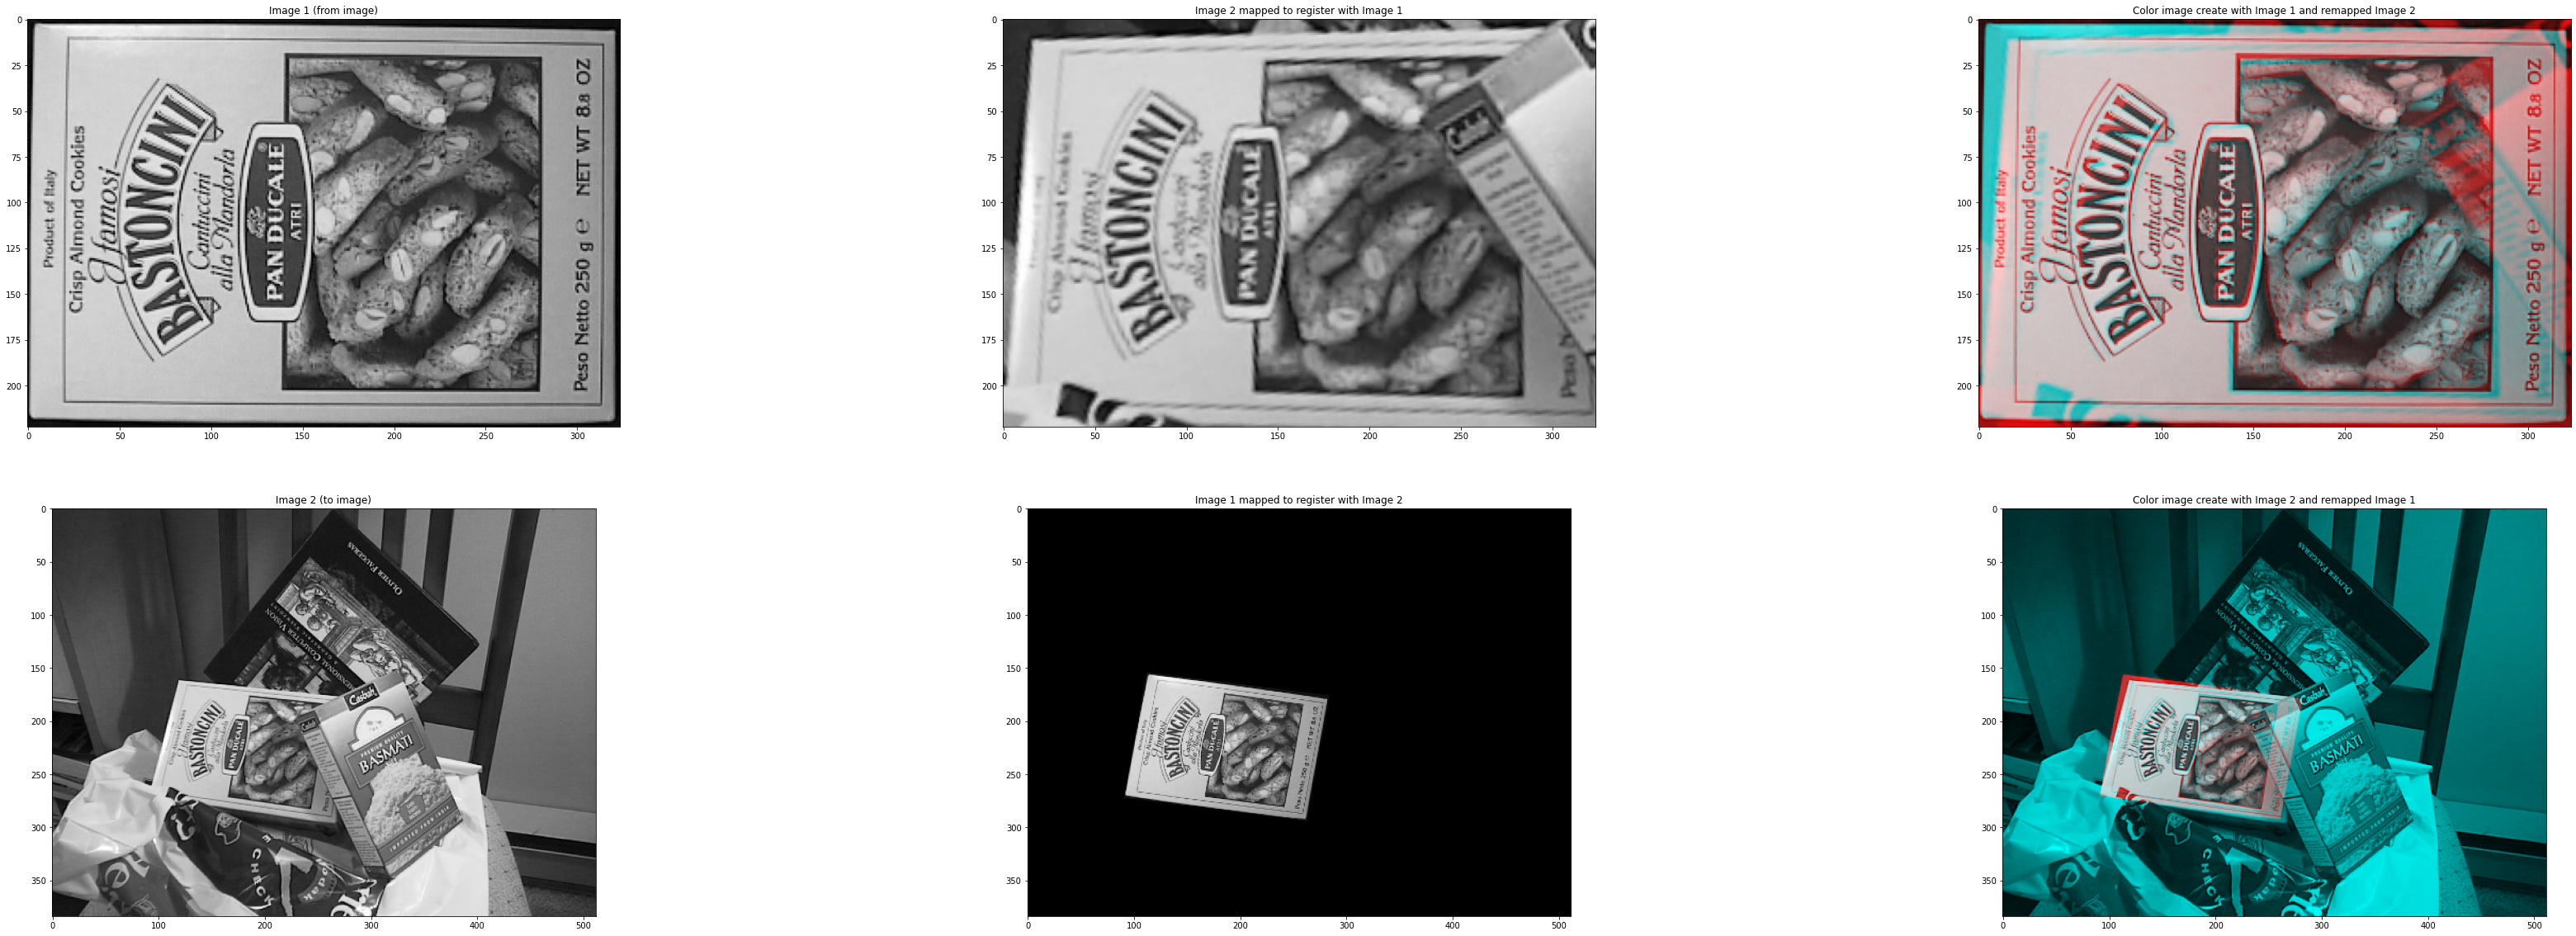

In [107]:
from skimage.transform import warp

residual_error, T_affine, selected_matches = fit_affine_remove_outliers(X_1, X_2, 1)
print(selected_matches)
T_affine_inv = np.linalg.inv(T_affine)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual_error, T_affine, T_affine_inv))


warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (60, 20))
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1');


In [106]:
def fit_affine_remove_outliers (Points_1, Points_2, acceptable_error = 2) :
    # input: two 2D points sets, each of size N by 2
    # output: residual of fit and the best fitting affine transformation
    # acceptable_error - amount of average pixel error that is acceptable

    # Rearrange the points in 3 by N arrays of homogeneous representation of the points
    X = np.row_stack((Points_1.transpose(1,0), np.ones((1, Points_1.shape[0]))))
    X_dash = np.row_stack((Points_2.transpose(1,0), np.ones((1, Points_2.shape[0]))))
    
    weights = np.eye(X.shape[1])
    average_residual_error = np.sqrt(np.sum(np.power(X - X_dash, 2)/X.shape[1]))
    while average_residual_error > acceptable_error :
        # Compute the Hessian from the point coordinate moments
        M = X @ weights @ X.transpose(1,0)
        A1 = np.column_stack((M, np.zeros((3,3))))
        A2 = np.column_stack((np.zeros((3,3)), M))
        A = np.row_stack((A1, A2))
        #print('A =\n', A)

        # vector b
        b_dash = X @ weights @(X_dash - X).transpose(1,0)
        b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))
        #print('b =\n', b)

        p = qr_solve (A, b) 

        p = p.squeeze()
        # the parameter vector is [a_00, a_01, t_x, a_10, a_11, t_y]
        # rearrange it back into homogeneous matrix representation
        T_affine = np.row_stack((p.reshape(2, 3), [0, 0, 0])) + np.eye(3)
        T_affine_inv = np.linalg.inv(T_affine)

        X_t = T_affine @ X
        error =  (X_dash - X_t) @ weights
        residual_error = np.sum(np.power(error, 2), axis=0)
        average_residual_error = np.sqrt(np.sum(residual_error)/np.sum(weights))

        max_index = np.argmax(residual_error)
        weights[max_index, max_index] = 0

        print('residual error = {}, remove match # {}'.format(average_residual_error, max_index))

    return(average_residual_error, T_affine, np.diag(weights))